In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math

# Parameters

In [2]:
# max integer
N = 2000

# weight parameters
alpha = 1.
beta = 1.

# curvature parameters
gamma = 0.1

# num of eigenfunctions
num_func = 20

In [3]:
xs = np.arange(N)
cs = np.ones(N - 1) # (1 + xs[:-1]) ** gamma
ws = (1 + xs) ** (-beta)

cs /= np.max(cs)
ws /= np.max(ws)

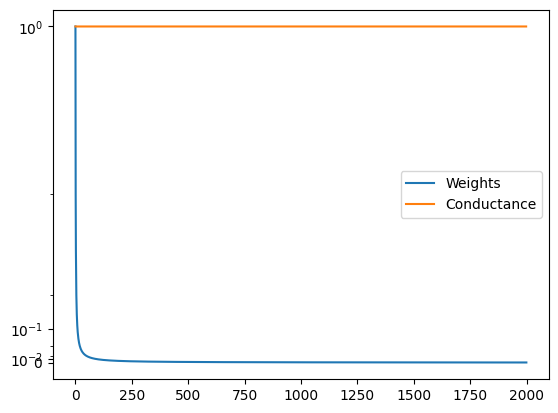

In [4]:
plt.plot(xs, ws, label='Weights')
plt.plot(xs[:-1], cs, label='Conductance')
plt.yscale('asinh', linear_width=10)
plt.legend()
plt.show()

# Compute basis functions

In [5]:
def build_cs_matrix(cs):
    head = cs[:-1]
    tail = cs[1:]
    main_diagonal = np.r_[head[0], head + tail, tail[-1]]
    off_diagonal = -cs
    return scipy.sparse.diags_array(
        (off_diagonal, main_diagonal, off_diagonal),
        offsets=[-1, 0, 1],
    )

def compute_eigenfunctions(cs, ws, k):
    cs_mat = build_cs_matrix(cs)
    ds_mat = scipy.sparse.diags_array((1 / np.sqrt(ws)))
    eig_mat = ds_mat @ cs_mat @ ds_mat

    main_diag = eig_mat.diagonal(0)
    off_diag = eig_mat.diagonal(-1)
    vals, vecs = scipy.linalg.eigh_tridiagonal(main_diag, off_diag, select='i', select_range=(0, k - 1))
    ortho_vecs = (vecs.T / np.sqrt(ws)).T
    return vals, ortho_vecs

In [6]:
vals, vecs = compute_eigenfunctions(cs, ws, num_func)

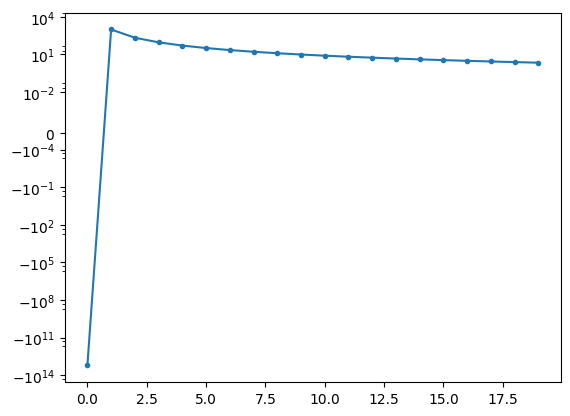

In [7]:
plt.plot(np.reciprocal(vals), marker='o', markersize=3)
plt.yscale('asinh', linear_width=1e-5)
plt.show()

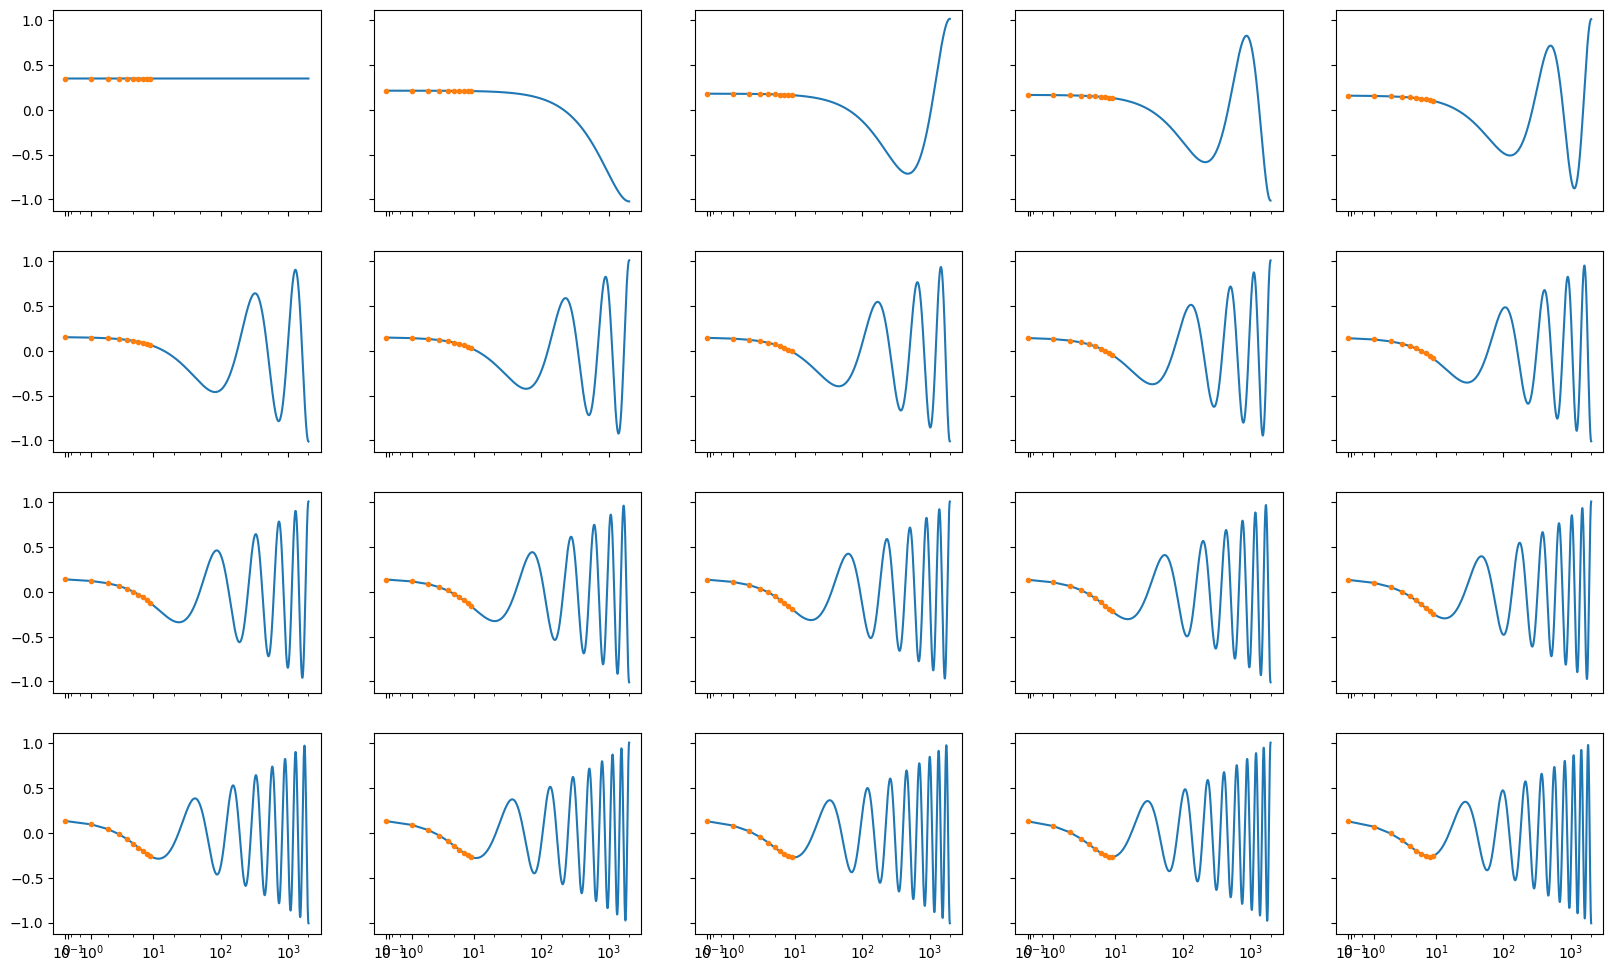

In [8]:
rows = math.floor(math.sqrt(num_func))
cols = math.ceil(num_func / rows)
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), sharex=True, sharey=True)
for i in range(num_func):
    ax = axs[i // cols, i % cols]
    ax.plot(xs, vecs[:, i])
    ax.plot(xs[:10], vecs[:10, i], marker='o', markersize=3, linestyle='None')
    ax.set_xscale('asinh')
plt.show()

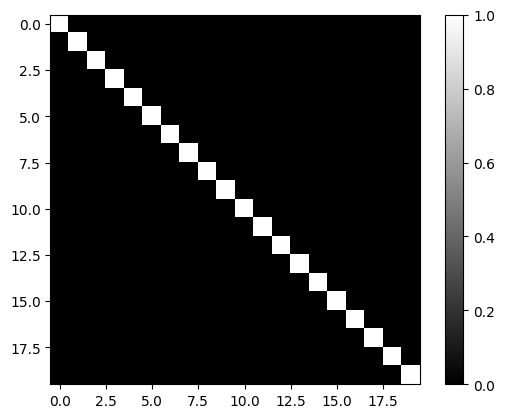

In [9]:
plt.imshow(vecs.T * ws @ vecs, cmap='gray')
plt.colorbar()
plt.show()

# Test approximation power

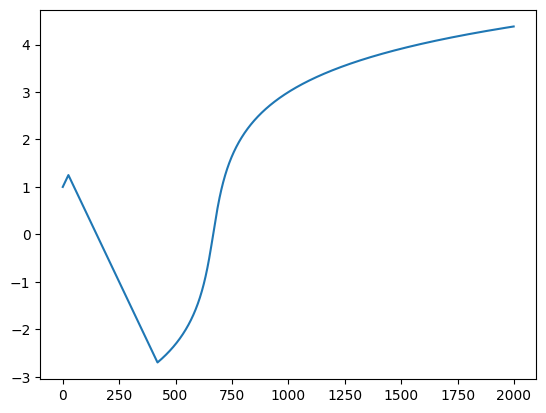

In [10]:
def test_func(xs):
    return np.maximum(
        np.minimum(
            0.01 * xs + 1,
            -0.01 * xs + 1.5,
        ),
        np.asinh(0.03 * xs - 20)
    )

plt.plot(xs, test_func(xs), label='Original function')
plt.show()

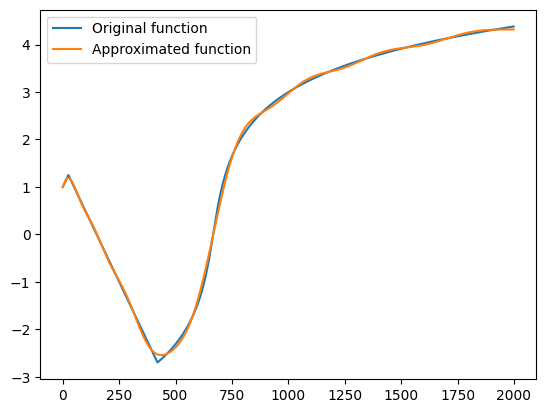

In [11]:
vec_norms_sq = np.sum(np.square(vecs).T * ws, axis=1).T
coefficients = (test_func(xs) * ws) @ vecs / vec_norms_sq   # project the function onto our basis
apx_func_vals = vecs @ coefficients          # reconstruct the function as a linear combination of the basis functions
plt.plot(xs, test_func(xs), label='Original function')
plt.plot(xs, apx_func_vals, label='Approximated function')
plt.legend()
plt.show()

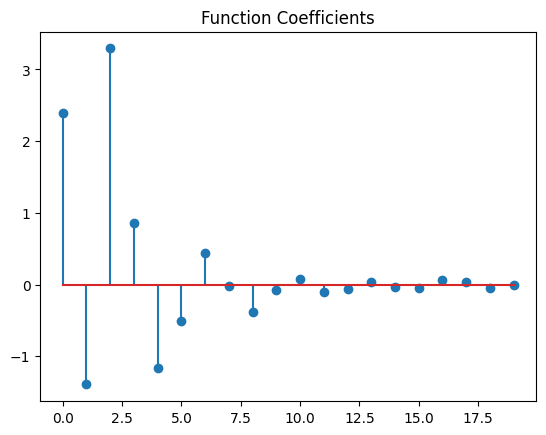

In [12]:
plt.stem(coefficients)
plt.title('Function Coefficients')
plt.show()

# Test learning

In [13]:
train_size = 200
test_size = 10000
label_noise = 0.1

In [14]:
def rmse(pred, label):
    return np.sqrt(np.mean(np.square(pred - label)))

In [15]:
class StrumLiouvilleBasis:
    def __init__(self, *, max_val=2000, num_funcs=20, weight_config=(1, 1), curvature_config=0.1):
        """Initializes a Strum-Liouville basis with given parameters.

        Args:
            max_val (int): The maximum value for the basis functions.
            num_funcs (int): The number of basis functions to compute.
            weight_config (tuple or np.ndarray): A tuple containing the weight parameters (alpha, beta).
            curvature_config (float or np.ndarray): The curvature parameter(s).
        """
        self.max_val = max_val
        match weight_config:
            case (alpha, beta) if alpha > 0 and beta > 0:
                self.weights = 1 / (1 + np.arange(max_val)) ** beta
            case np.ndarray() as ws if len(ws) == max_val and np.all(ws > 0):
                self.weights = ws
        self.weights /= np.sum(self.weights)

        match curvature_config:
            case float() as gamma if gamma > 0:
                self.cs = (1 + np.arange(max_val - 1)) ** gamma
            case np.ndarray() as cs if len(cs) == max_val - 1 and np.all(cs > 0):
                self.cs = cs / np.max(cs)
        self.num_funcs = num_funcs
        self.eigenfunctions_ = None
        self.eigenvalues_ = None

    def __call__(self, xs):
        if self.eigenfunctions_ is None:
            self.eigenvalues_, self.eigenfunctions_ = compute_eigenfunctions(self.cs, self.weights, self.num_funcs)

        orig_shape = xs.shape
        xs = np.minimum(xs.flatten(), self.max_val)
        vander = self.eigenfunctions_[xs, :]
        return vander.reshape((*orig_shape, self.num_funcs))

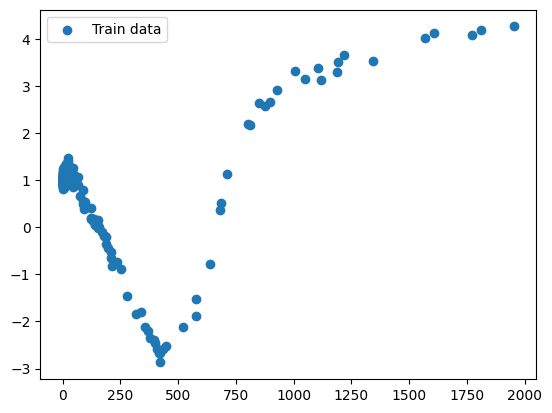

In [16]:
slb_vander = StrumLiouvilleBasis()
train_xs = np.random.choice(slb_vander.max_val, p=slb_vander.weights, size=train_size)
train_ys = test_func(train_xs) + label_noise * np.random.randn(len(train_xs))
plt.scatter(train_xs, train_ys, label='Train data')
plt.legend()
plt.show()

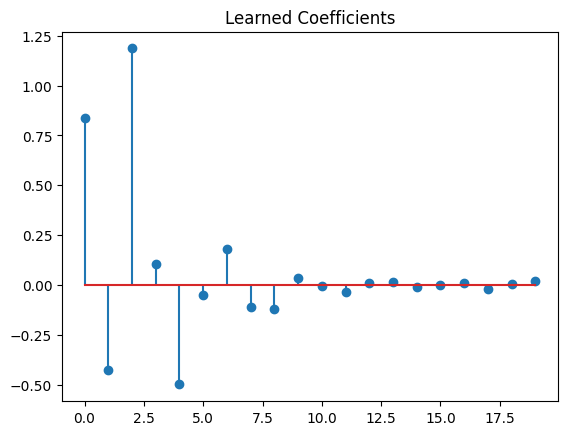

In [17]:
coefs = np.linalg.lstsq(slb_vander(train_xs), train_ys, rcond=None)[0]
plt.stem(coefs)
plt.title('Learned Coefficients')
plt.show()

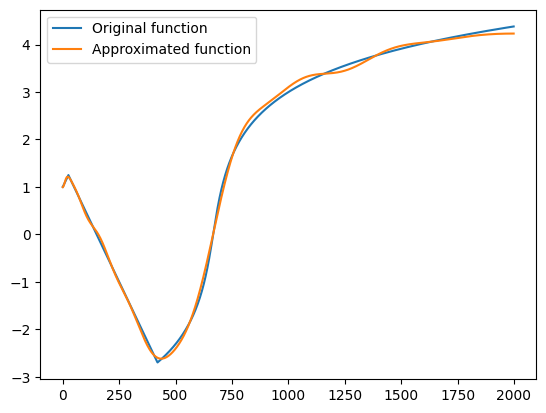

In [18]:
plot_xs = np.arange(slb_vander.max_val)
plt.plot(plot_xs, test_func(plot_xs), label='Original function')
plt.plot(plot_xs, slb_vander(plot_xs) @ coefs, label='Approximated function')
plt.legend()
plt.show()

In [19]:
test_xs = np.random.choice(slb_vander.max_val, p=slb_vander.weights, size=test_size)
pred = slb_vander(test_xs) @ coefs
print(f'Test RMSE: {rmse(pred, test_func(test_xs)):.6f}')

Test RMSE: 0.046342


In [20]:
ood_weights = np.cbrt(slb_vander.weights)
ood_weights /= np.sum(ood_weights)
odd_test_xs = np.random.choice(slb_vander.max_val, p=ood_weights, size=test_size)
ood_pred = slb_vander(odd_test_xs) @ coefs
print(f'OOD Test RMSE: {rmse(ood_pred, test_func(odd_test_xs)):.6f}')

OOD Test RMSE: 0.074958


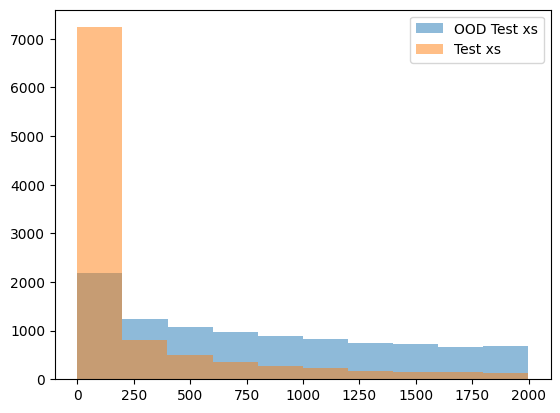

In [21]:
plt.hist(odd_test_xs, alpha=0.5, label='OOD Test xs')
plt.hist(test_xs, alpha=0.5, label='Test xs')
plt.legend()
plt.show()

# Geometric binning comparison

In [22]:
def geometric_bins(num_bins):
    bins = np.r_[0, 1, np.geomspace(1, slb_vander.max_val, num_bins - 1)]
    return bins

In [23]:
def equal_weight_bins(num_bins):
    weights_sum = np.cumsum(slb_vander.weights)
    bin_edges = np.linspace(0, 1, num_bins + 1)
    bins = np.searchsorted(weights_sum, bin_edges)
    bins[0] = 0
    bins[-1] = slb_vander.max_val
    return np.unique(bins)

In [24]:
bins = geometric_bins(slb_vander.num_funcs)
# bins = equal_weight_bins(slb_vander.num_funcs)

In [25]:
def onehot(xs):
    digits = np.digitize(xs, bins, right=True)
    identity = np.eye(len(bins))
    return identity[digits]

In [26]:
bin_coefs = np.linalg.lstsq(onehot(train_xs), train_ys, rcond=None)[0]

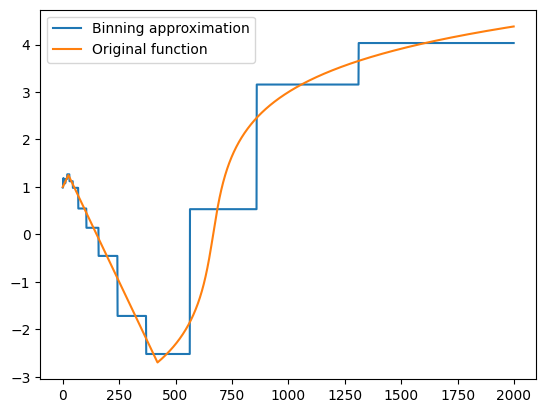

In [27]:
plt.plot(plot_xs, onehot(plot_xs) @ bin_coefs, label='Binning approximation')
plt.plot(plot_xs, test_func(plot_xs), label='Original function')
plt.legend()
plt.show()

In [28]:
bins_pred = onehot(test_xs) @ bin_coefs
print(f'Binning Test RMSE: {rmse(bins_pred, test_func(test_xs)):.6f}')

Binning Test RMSE: 0.362196


In [29]:
bins_ood_pred = onehot(odd_test_xs) @ bin_coefs
print(f'Binning OOD Test RMSE: {rmse(bins_ood_pred, test_func(odd_test_xs)):.6f}')

Binning OOD Test RMSE: 0.600955


# Compare with splines

In [30]:
def augknt(knots, degree):
    """Augment the knot vector for B-spline basis functions."""
    if degree < 1:
        raise ValueError("Degree must be at least 1.")
    # Repeat the first and last knots degree times
    return np.concatenate(([knots[0]] * degree, knots, [knots[-1]] * degree))

In [31]:
class SplineVander:
    def __init__(self, bins, degree=3):
        self.degree = degree
        self.knots = augknt(bins, degree)

    def __call__(self, xs):
        return scipy.interpolate.BSpline.design_matrix(xs, self.knots, self.degree).todense()

In [32]:
spl_vander = SplineVander(bins)

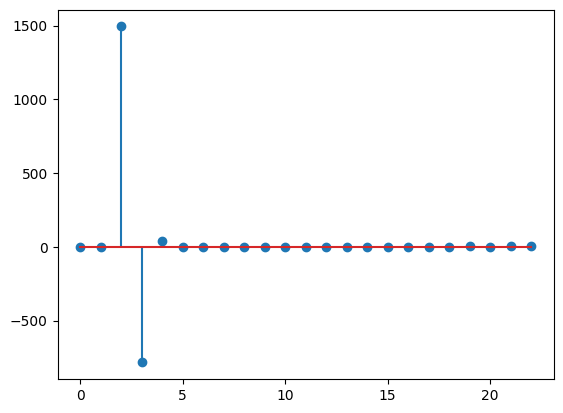

In [33]:
spl_coef = np.linalg.lstsq(spl_vander(train_xs), train_ys, rcond=None)[0]
plt.stem(spl_coef)
plt.show()

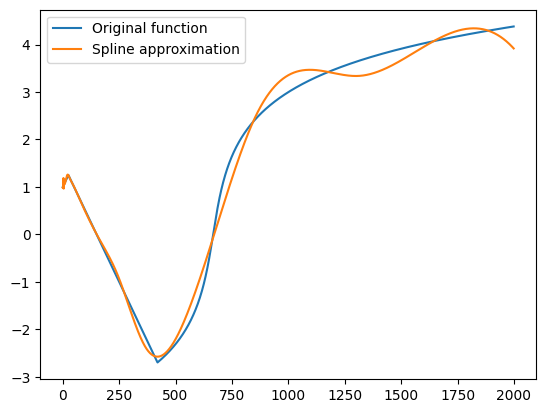

In [34]:
plt.plot(plot_xs, test_func(plot_xs), label='Original function')
plt.plot(plot_xs, spl_vander(plot_xs) @ spl_coef, label='Spline approximation')
plt.legend()
plt.show()

In [35]:
spl_pred = spl_vander(test_xs) @ spl_coef
print(f"Spline RMSE: {rmse(spl_pred, test_func(test_xs))}")

Spline RMSE: 0.12278824930754778


In [36]:
spl_ood_pred = spl_vander(odd_test_xs) @ spl_coef
print(f"Spline OOD RMSE: {rmse(spl_ood_pred, test_func(odd_test_xs))}")

Spline OOD RMSE: 0.2089375000074219
